# Analysis Notebook
This Jupyter notebook contains important plots present in the paper with relevant descriptions. The first cell contains importing of relevant packages and code, make sure dependencies are fulfilled and compatible. 

The notebook is divided into sections:
- [Initializing](#initializing)
- [Emulator Training and Validation](#emulator-description)
- [Results: Posterior Distribution](#corner-plot)
- [Calculations using Model Parameters](#calculations-using-model-parameters)


In [36]:
from my_plotting import *
from my_functions import *
sns.set()
sns.set_style('ticks')
plt.rcParams.update({'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'axes.labelsize': 18,
                     'axes.titlesize': 22,
                     'legend.fontsize': 16,
                     'legend.title_fontsize': 14,
                     #'figure.autolayout': True,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',})
from scipy.optimize import basinhopping
import warnings
warnings.filterwarnings('ignore')

## Initializing
Load important files and data:
- pickled emulator, pca, and scaler
- training and validation set
- parameter set
- experimental data in relevant kinematical range
- parameter samples
- posterior samples (or just sample from the complete set)
- model values for posterior samples

In [37]:
# first decide if we are dealing with correlated setup and which model
correlated_ = True 
model_ = "mve" # or "mv5" for the 5 parameter case

In [38]:
correlated_str = "corr" if correlated_ else "uncorr"
param_names = ["$Q_{s,0}^{2}$ [GeV²]",
               "$\gamma$ ",
               "$e_c$ ",
               "$C^2$ ",
               "$\sigma_0/2$ [mb] "] if model_ == "mv5" else ["$Q_{s,0}^{2}$ [GeV²]",
               "$e_c$ ",
               "$C^2$",
               "$\sigma_0/2$ [mb]"]
n_params = 5 if model_ == "mv5" else 4
# all files
folder = 'data/' + model_ + '/' + correlated_str
exp_file = "data/hera_allerrors.csv"
gpe_pkl = folder+"/gpe.pkl"
pca_pkl = folder+"/pca.pkl"
scaler_pkl = folder+"/scaler.pkl"
train_file, theta_file = 'data/'+model_+"/training/train.dat", 'data/' +model_+"/training/theta.dat"
train_file_val, theta_file_val = 'data/'+model_+"/validation/train.dat", 'data/'+model_+"/validation/theta.dat"
theta_post_all_file = folder+"/theta_all.dat"
train_file_post, theta_file_post = folder+"/train.dat", folder+"/theta.dat"
theta_post_1000_file = folder+"/theta_1000.dat"
mean_model_file = folder+"/mean.dat"
median_model_file = folder+"/median.dat"
map_model_file = folder+"/map.dat"

In [39]:
# load from files 
# Emulator and emulator predictions
# gpe = load(gpe_pkl, mmap_mode='r') 
# pca = load(pca_pkl)
# scaler = load(scaler_pkl)
# emulators = [gpe, pca, scaler]
# error message:
# fix error with __randomstate_ctor() takes from 0 to 1 positional arguments but 2 were given
# sklearn version compatibitility does not fix, try overall package compatibility

# emulator training
train, theta = load_training_data(train_file, theta_file)
npc =  6 # dont change
emulators = train_PCA_GPE(train, theta, primary_components = npc, noise_level_bounds_= (1e-10, 1e1), show_var = True)
pred, err = return_predictions(emulators, theta, correlated=correlated_)

# emulator validation
train_val, theta_val = load_training_data(train_file_val, theta_file_val)
pred_val, err_val = return_predictions(emulators, theta_val, correlated=correlated_)

# emulator and bayesian posterior validation
train_post, theta_post = load_training_data(train_file_post, theta_file_post)
pred_post, err_post = return_predictions(emulators, theta_post, correlated=correlated_)

# Posterior samples
theta_post_all = np.vstack(np.loadtxt(theta_post_all_file))
theta_post_1000 = np.vstack(np.loadtxt(theta_post_1000_file, comments="#"))

# Experimental dataframe with columns:
exp_df, exp, exp_err, xbj = load_exp(exp_file, correlated = correlated_)

# bounds of the prior
l_bounds = [0.04, 0.9, 0.5, 2.0, 12.0] if model_ == "mv5" else [0.04, 0.5, 2.0, 12.0]
u_bounds = [0.11, 1.1, 60.0, 10.0, 18.0] if model_ == "mv5" else [0.11, 60.0, 10.0, 18.0]

# mean, median and map values
median = np.median(theta_post_all, axis=0).reshape(1,-1)
mean = np.mean(theta_post_all, axis=0).reshape(1,-1)
median_84= np.percentile(theta_post_all, 84, axis=0).reshape(1,-1)
median_16= np.percentile(theta_post_all, 16, axis=0).reshape(1,-1)
MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err, correlated = correlated_), median.reshape(-1)).x
MAP = MAP.reshape(1,-1)

# get model calculations with mean, median and map values
median_model = np.loadtxt(median_model_file)
mean_model = np.loadtxt(mean_model_file)
MAP_model = np.loadtxt(map_model_file)

Explained variance ratio: [9.935e-01 6.231e-03 2.661e-04 4.348e-05 1.207e-06 5.001e-07]
Sum of explained variance ratio: 0.9999999648381943


In [40]:
# set display print options to 3 significant digits
np.set_printoptions(precision=3)
print("Mean", mean)
print("Median", median)
print("+", median_84 - median)
print("-", median - median_16)
print("MAP", MAP)

Mean [[ 0.062 35.54   5.081 14.156]]
Median [[ 0.061 35.292  4.973 14.14 ]]
+ [[6.672e-03 1.609e+01 1.005e+00 5.532e-01]]
- [[4.401e-03 1.508e+01 7.828e-01 5.200e-01]]
MAP [[ 0.06  38.897  4.604 13.92 ]]


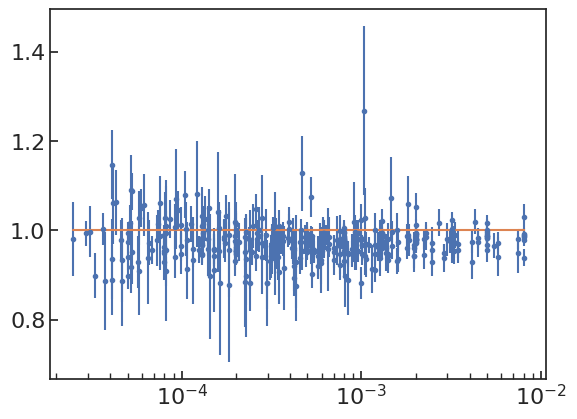

In [41]:
y = median_model - exp
exp_err_diag = np.sqrt(np.diag(exp_err))
exp_err_diag_alt = np.sqrt(exp_df['uncor_tot']**2 + exp_df['cor_wo_proc']**2)
# max of y
xrange = xbj #np.linspace(0.01, 0.1, 403)
plt.errorbar(xrange, median_model/exp, yerr= exp_err_diag/exp, fmt= '.')
plt.plot(xrange, exp/exp, '-')
plt.xscale('log')

In [42]:
perc = (np.abs(y)/exp)*100
print('average percent difference:', np.mean(perc))

average percent difference: 3.7204546554409887


In [43]:
# chi² or likelihood values of mean, median and MAP
print(" -- chi2/dof values for mean, median, MAP, and average over 100 posterior samples such that the correlation among uncertainties were not considered -- " )
print("mean:", get_chi2(mean_model, exp, np.sqrt(np.diag(exp_err)), correlated = False, model = model_))
print("median:", get_chi2(median_model, exp, np.sqrt(np.diag(exp_err)), correlated = False, model=model_))
print("MAP:", get_chi2(MAP_model, exp, np.sqrt(np.diag(exp_err)), correlated = False, model=model_))
all_chi2 = []
for i in range(100):
    all_chi2.append(get_chi2(train_post[i], exp, np.sqrt(np.diag(exp_err)), correlated = False, model = model_))
print('for 100 samples:', np.mean(all_chi2))

 -- chi2/dof values for mean, median, MAP, and average over 100 posterior samples -- 
mean: 1.1065833773971783
median: 1.7170936048238852
MAP: 2.054549766675898
for 100 samples: 2.217800578242051


In [ ]:
# chi² or likelihood values of mean, median and MAP
print(" -- chi2/dof values for mean, median, MAP, and average over 100 posterior samples -- " )
print("mean:", get_chi2(mean_model, exp, exp_err, correlated = False, model = model_))
print("median:", get_chi2(median_model, exp, exp_err, correlated = False, model=model_))
print("MAP:", get_chi2(MAP_model, exp, exp_err, correlated = False, model=model_))
all_chi2 = []
for i in range(100):
    all_chi2.append(get_chi2(train_post[i], exp, exp_err, correlated = False, model = model_))
print('for 100 samples:', np.mean(all_chi2))

## Emulator Description
The training set is generated by sampling the parameter space with a latin hypercube design. The parameter space is defined by the following parameters: $Q_{s0}^2$, $\gamma$, $e_c$, $C^{2}$, $\sigma_0/2$. The final prior bounds used in the study is a result of multiple iterations of the Bayesian sampling and each time making, what was initially, a very generous parameter space even smaller for better emulator predictions. In a latin hypercube, the parameter vectors for the model to be calculated on and the emulator to be trained on are sampled evenly across the space such that there is no redundancy in each individual parameter.

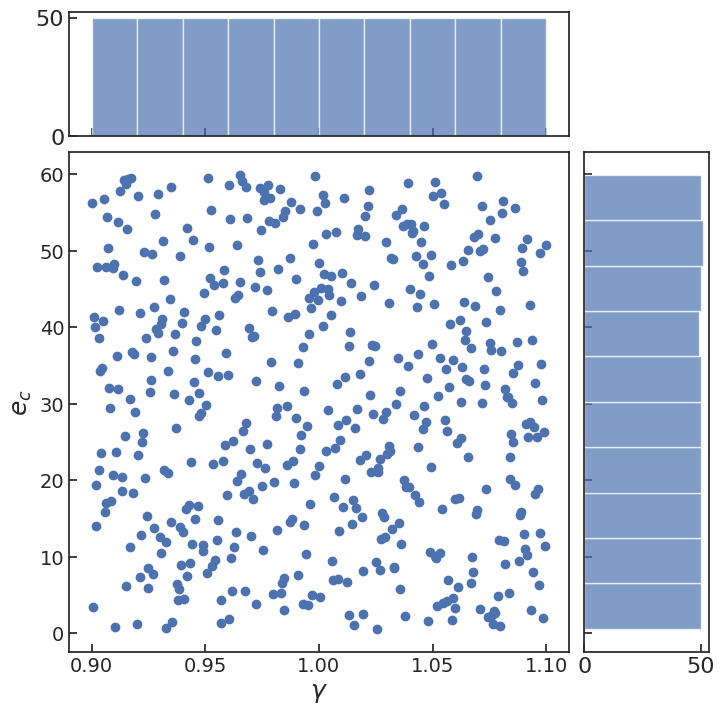

In [27]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
scatter_hist(1, 2, ax, ax_histx, ax_histy, theta, param_names)

### Emulator Validation
The following shows comparison of emulator prediction to HERA data and model calculation to a validation set of 100 parameter vectors to validate the emulator before feeding it into the bayesian sampler.

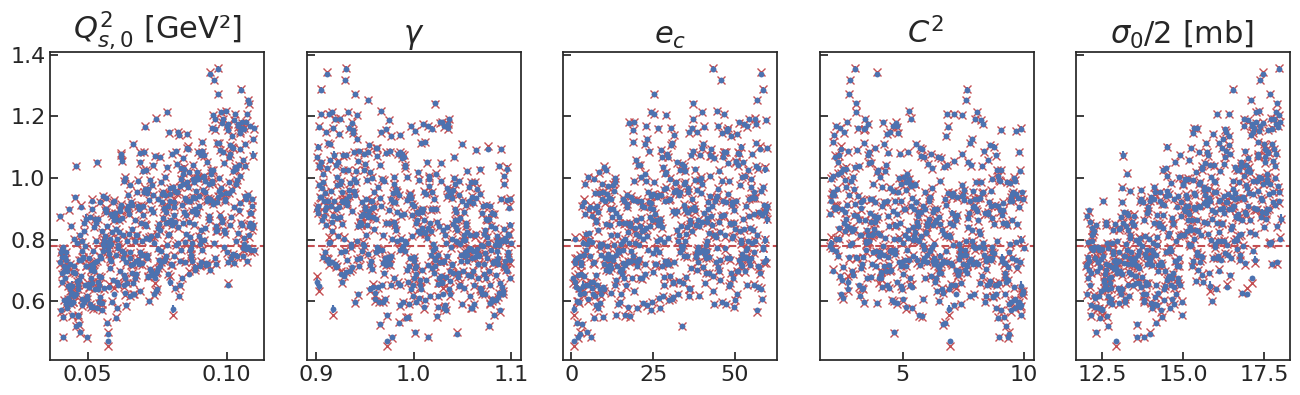

In [28]:
kp = 0
sd_val = np.sqrt(np.diagonal(err_val, axis1 = 1, axis2 = 2)) if correlated_ else err_val
fig, ax = plot_validation_perkp(0, pred_val, sd_val, train_val, exp, n_params, theta_val, param_names)

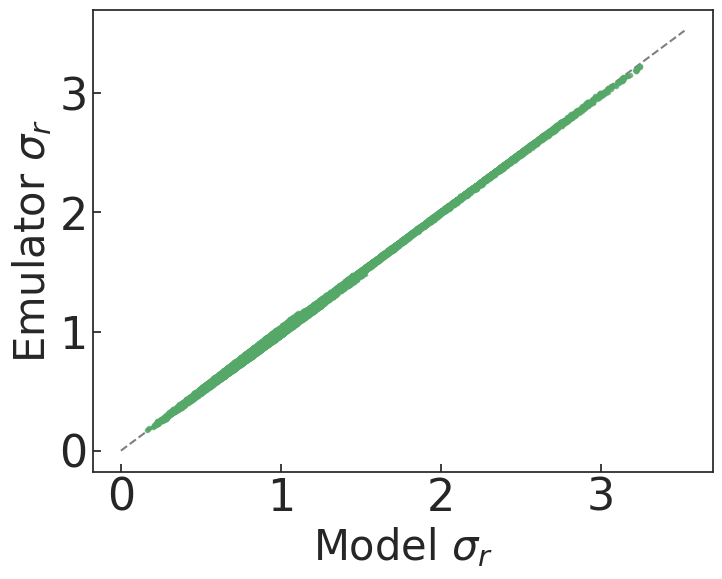

In [29]:
fig, ax = plot_diagonal(pred_val, train_val)
ax.xaxis.get_label().set_fontsize(30)
ax.yaxis.get_label().set_fontsize(30)
ax.tick_params(axis='both', which='major', labelsize=32)
fig.savefig("plots/{}_val_diagonal.pdf".format(model_), bbox_inches='tight')
fig.savefig("plots/{}_val_diagonal.png".format(model_), bbox_inches='tight')

In [30]:
diff = np.array([(pred_val[:,kp] - train_val[:,kp])/train_val[:,kp] for kp in range(403)])
mean_pertheta = np.mean(diff, axis=1)
mean_all = np.mean(mean_pertheta)
print("mean relative error =", mean_all)

mean relative error = 0.0004730141161155856


norm_fit =  0.8435505624553132


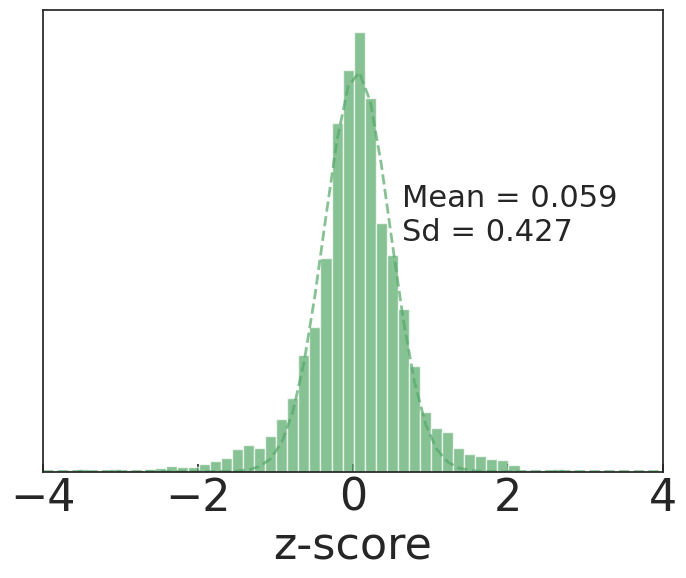

In [31]:
fig, ax = plot_zscore(pred_val, train_val, sd_val, bins_ = 80, text_x = 0.58, text_y = 0.5)
ax.set_yticklabels([])
ax.set_ylabel("")
ax.tick_params(which='major', axis = 'y', size = 0)
ax.set_xlim(-4.0, 4.0)
ax.xaxis.get_label().set_fontsize(32)
ax.tick_params(axis='x', which='major', labelsize=32)
#ax.legend(fontsize=22, loc='upper left')
fig.savefig("plots/{}_val_zscore_notarget.pdf".format(model_), bbox_inches='tight')

## Corner plot
Running the MCMC results to a posterior distribution describing the areas of high posterior probability. Diagonal plots of the triangle diagram are 1D projections of the posterior distribution for each parameter. The off-diagonal plots are 2D projections of the posterior distribution for each pair of parameters that show the correlation between the pair. The broken lines shows the parameter values at the posterior median, or the 50th percentile. Right after the corner plots, median and MAP values are printed for each parameter.

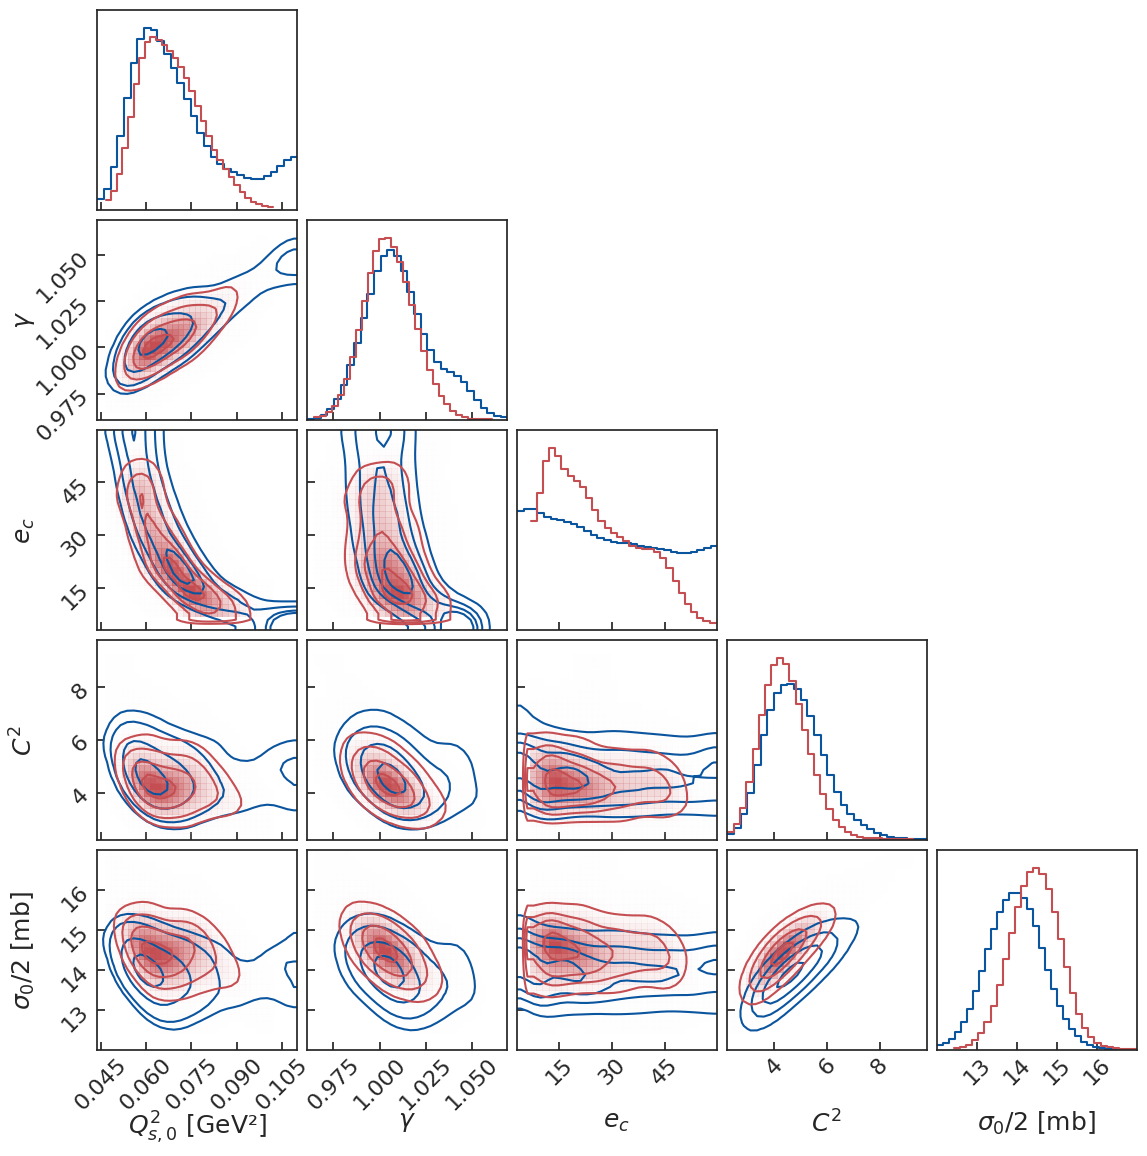

In [32]:
theta_tocompare = np.vstack(np.loadtxt("../BayesianBK/run_corr/mv5/plainLHS/run2_mv5_500d_uncorr_05to60_100w_mapinit_allsamples.txt", unpack = True)).T
fig2, corner = plot_1corner(theta_post_all, param_names, color_= '#0b559f')
plot_corner_tocompare(theta_tocompare, fig2, corner, color_ = 'r')
fig2.savefig("plots/corr_vs_uncorr_corner.pdf", bbox_inches='tight')

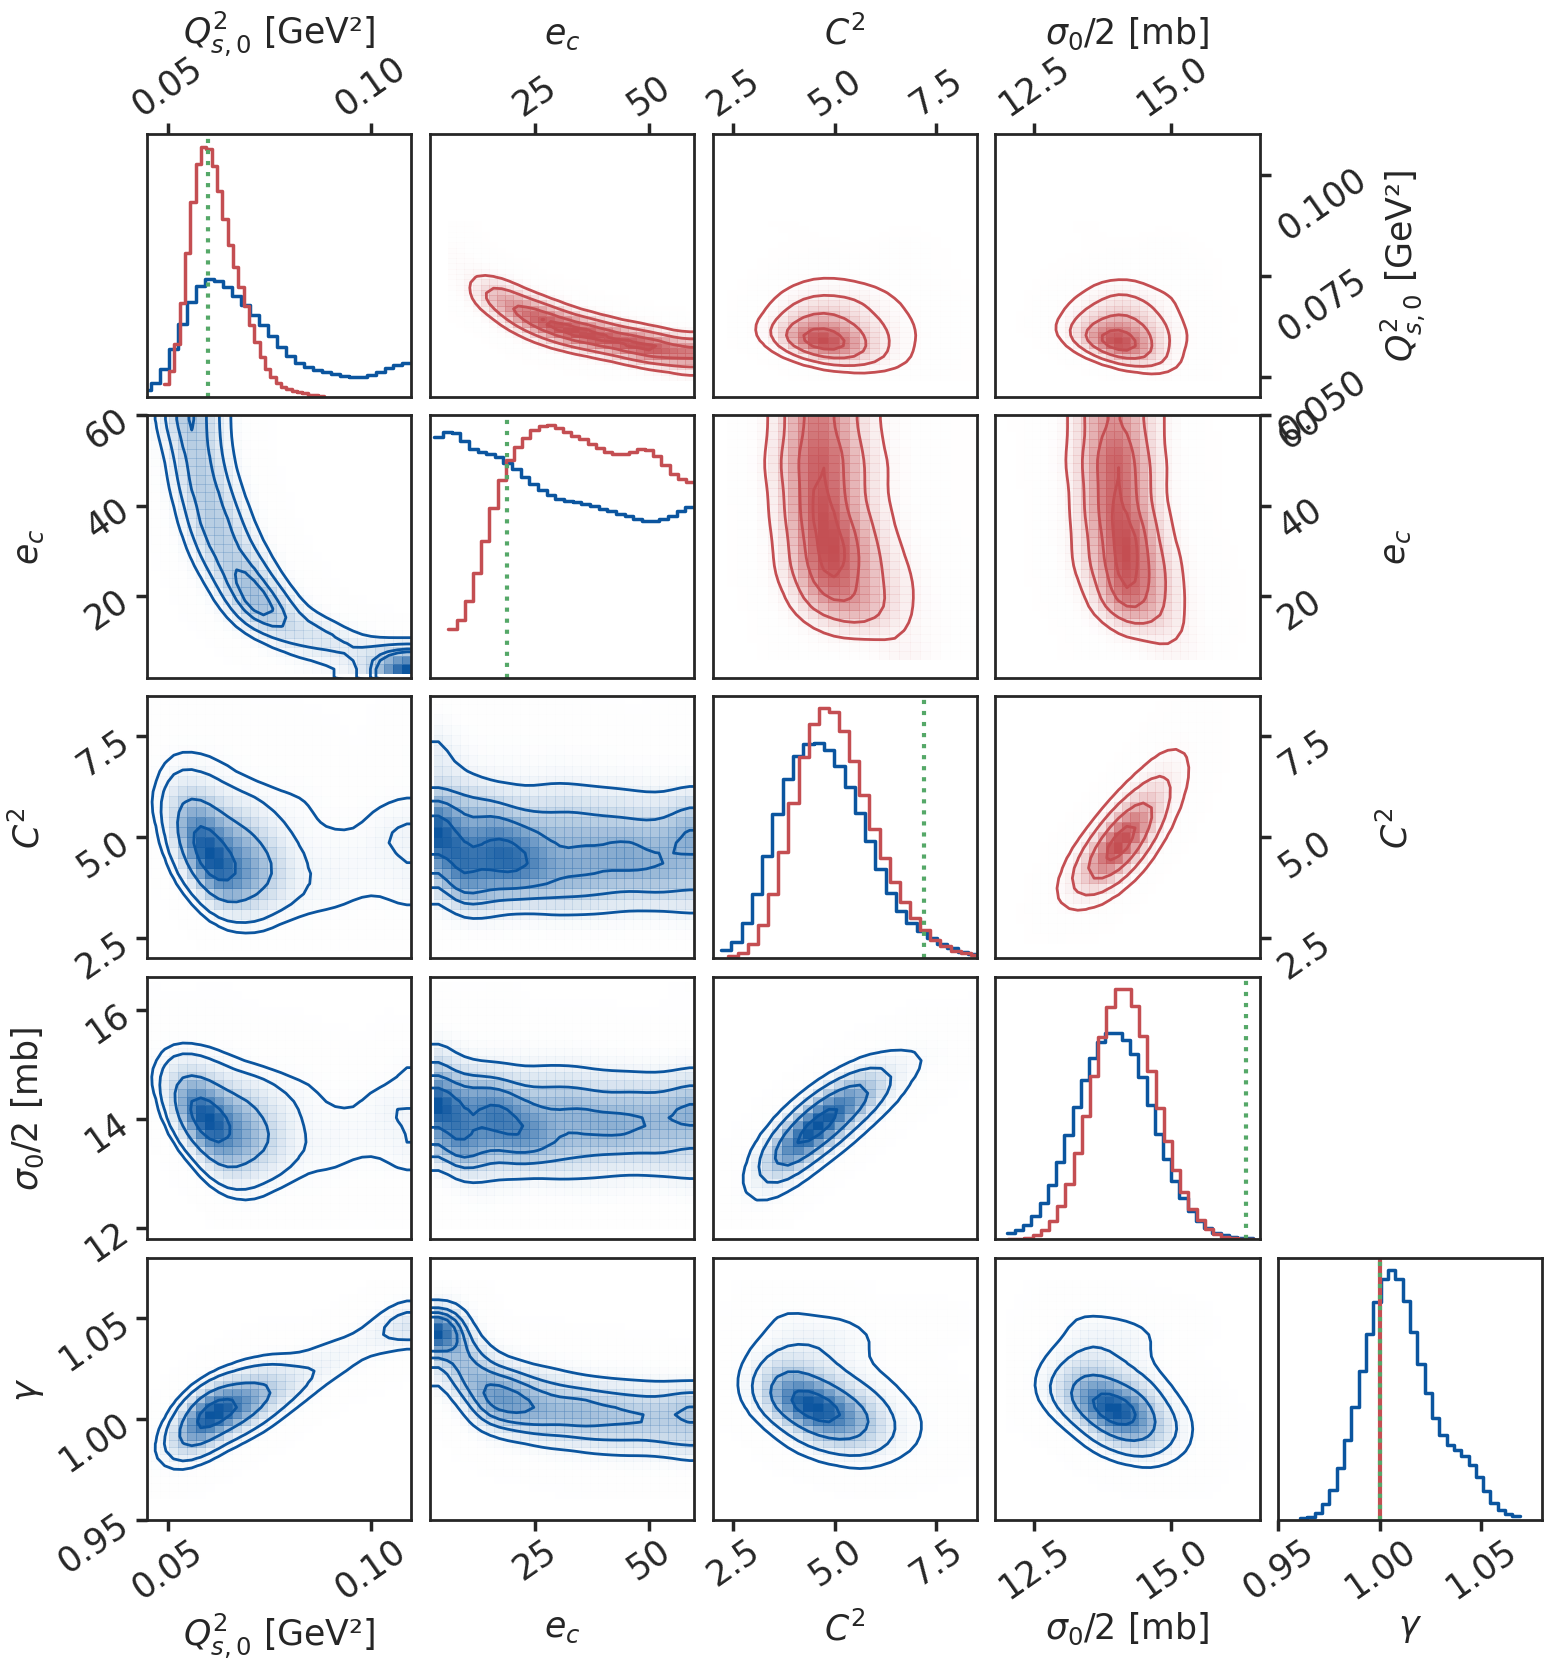

In [33]:
posterior_samples_mve= np.vstack(np.loadtxt("../BayesianBK/run_corr/mve/plainLHS/run2_mve_500d_{}_05to60_100w_mapinit_allsamples.txt".format(correlated_str), unpack=True)).T
posterior_samples_mv5 = theta_post_all
posterior_samples_mv5 = np.insert(posterior_samples_mv5, 5, posterior_samples_mv5[:, 1], axis = 1)
posterior_samples_mv5 = np.delete(posterior_samples_mv5, 1, axis = 1)
posterior_samples_mve_gamma = 1.0*np.ones(len(posterior_samples_mve))
posterior_samples_mve = np.insert(posterior_samples_mve, 4, posterior_samples_mve_gamma, axis = 1)
posterior_samples_mve[0:200, 4] = 1.0
fig_corner, axes = plot_corner(posterior_samples_mve, posterior_samples_mv5, color_mve = 'r', color_mv5='#0b559f')
fig_corner.savefig("plots/{}_corner_clean.pdf".format(correlated_str), bbox_inches='tight')

### Posterior Validation
Next we visualize different results from sampling from the posterior and then comparing to HERA data the model calculation at the MAP/ Median values.

In [34]:
median_emulator, median_emulator_err = return_predictions(emulators, median, correlated=correlated_)
MAP_emulator, MAP_emulator_err = return_predictions(emulators, MAP, correlated=correlated_)

KeyboardInterrupt: 

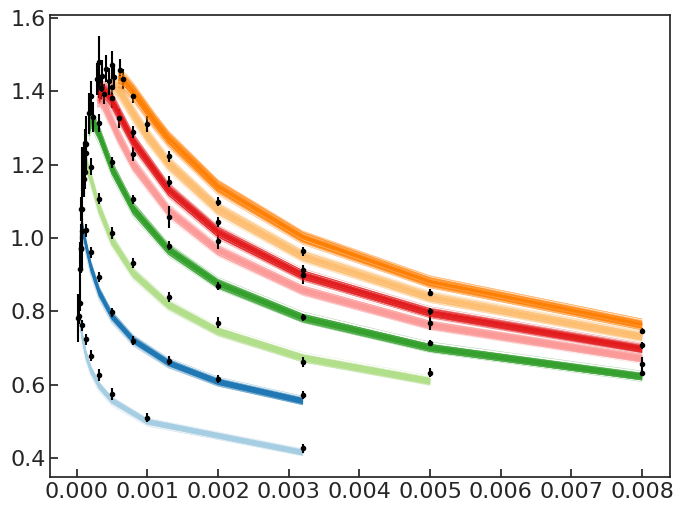

In [35]:
plot_model_vs_exp([2., 4.5, 8.5, 15.0, 22.0,  27.,  35.,  45.], 318.0, train_post, exp_df, exp_err, title_ = "{}-parameter fit".format(n_params), correlated = correlated_)
# other Q2 values 8.5, 15.0, 22.0,  27.,  35.,  45.

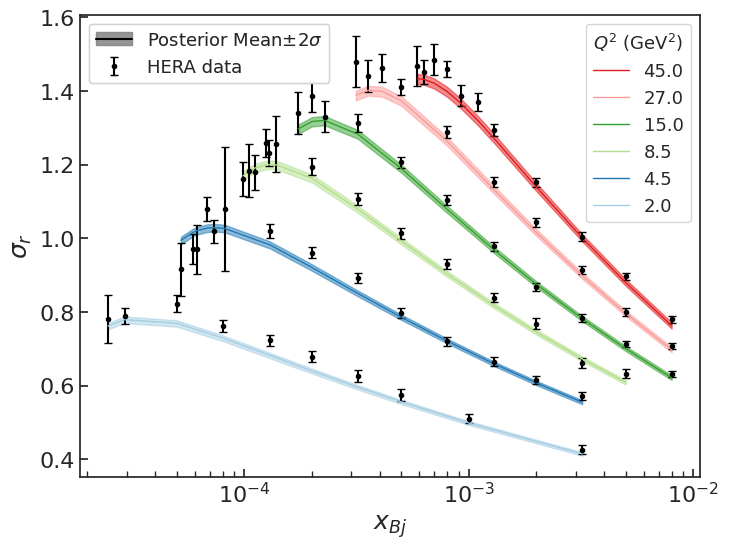

In [18]:
sqrt_s = 318
n_sigma = 2
fig, ax = plot_posterior_mean_and_ub([2., 4.5, 8.5, 15.0, 27., 45.], sqrt_s, train_post, exp_df, exp_err, n_sigma, title_ = "", correlated = correlated_)
fig.savefig("plots/{}_{}_{}_{}sigma_posterior_mean_and_ub.pdf".format(model_, correlated_str, sqrt_s, n_sigma), bbox_inches='tight')

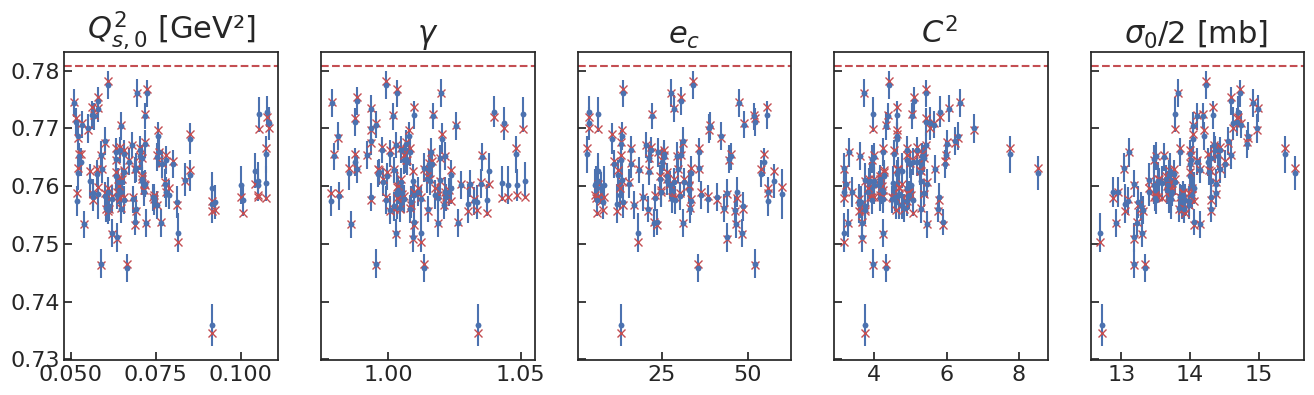

In [ ]:
sd_post = np.sqrt(np.diagonal(err_post, axis1 = 1, axis2 = 2)) if correlated_ else err_post
fig, ax = plot_validation_perkp(0, pred_post, sd_post, train_post, exp, n_params, theta_post, param_names)

norm_fit =  1.098572159032204


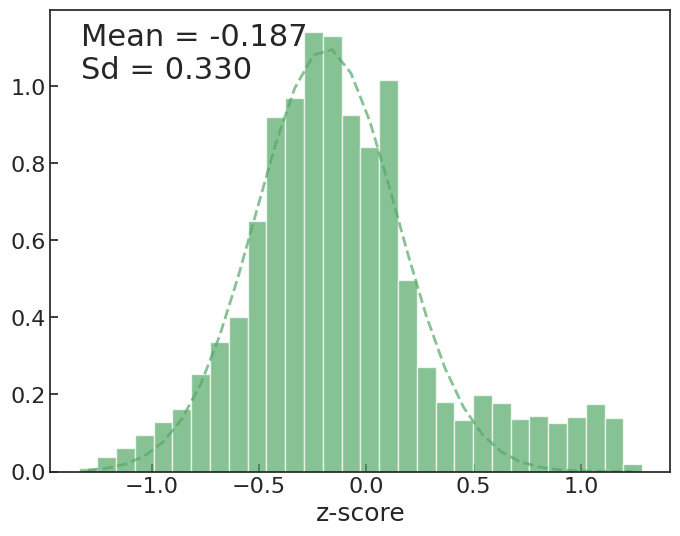

In [93]:
fig, ax = plot_zscore(pred_post, train_post, sd_post, text_x = 0.05, text_y = 0.85)

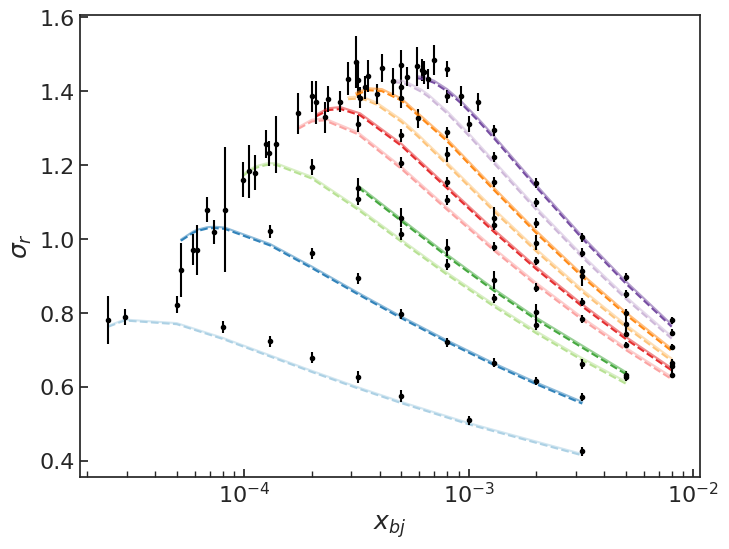

In [94]:
plot_exp_vs_map_vs_median([2., 4.5, 8.5, 10., 15., 18.,  22.,  27.,  35.,  45.], 318.0, MAP_model.reshape(1,403), exp_df, exp_err, median_model.reshape(1,403), correlated = correlated_)

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='Model $\\sigma_r$', ylabel='Emulator $\\sigma_r$'>)

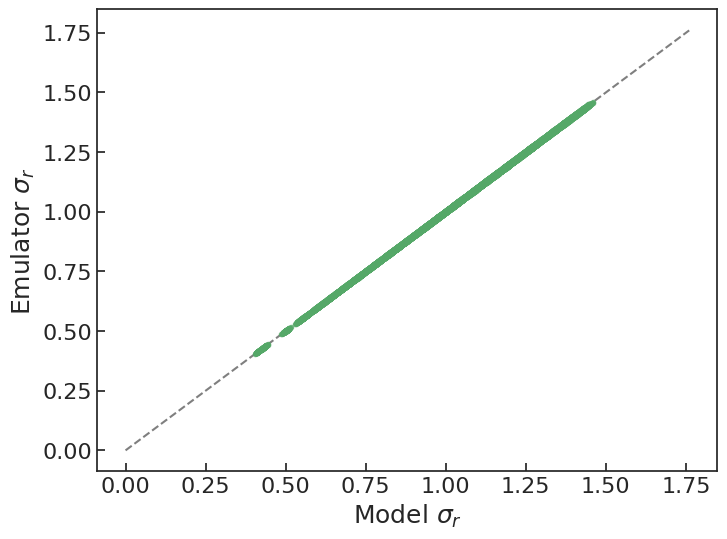

In [95]:
plot_diagonal(pred_post, train_post)

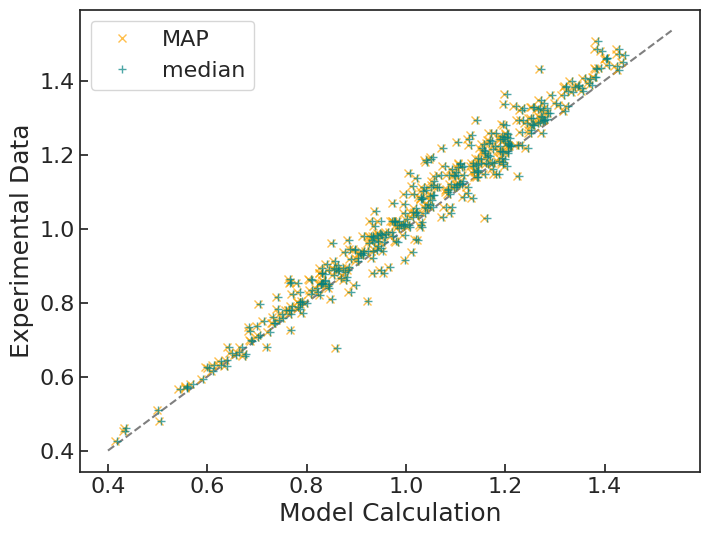

In [96]:
fig3, ax3 = plot_diagonal_1(MAP_model.reshape(403), exp, color_ = 'orange',label_ = "MAP")
ax3.plot(median_model.reshape(403), exp, '+', color = 'teal', alpha = 0.7, label  = "median" )
ax3.legend()
#fig3.savefig("plots/{}_{}_{}_diagonal.pdf".format(model_, correlated_str, 'mapnmedian'), bbox_inches='tight')

In [97]:
# print('MAP chi2', my_chi2(exp, MAP_model.reshape(403), np.sqrt(exp_err.diagonal()) if correlated_ else exp_err))
# print('median chi2', my_chi2(exp, median_model.reshape(403), np.sqrt(exp_err.diagonal()) if correlated_ else exp_err))
# print('mean chi2', my_chi2(exp, mean_model.reshape(403), np.sqrt(exp_err.diagonal()) if correlated_ else exp_err))

## Applications: Calculations using Model Parameters
For the following predictions, we take 1000 samples from the posterior distribution and statistically rigorously calculate the median and standard deviation by calculating the quantity for 1000 of the samples and take the mean and sd for each x-value. We demonstrate here how to properly propagate the BK initial condition uncertainty to CGC calculations.

Visually, there is no significant difference between the distributions of all parameters samples vs when we take only 1000 random samples meaning there is enough statistics in the posterior distributions made of 1000 samples.

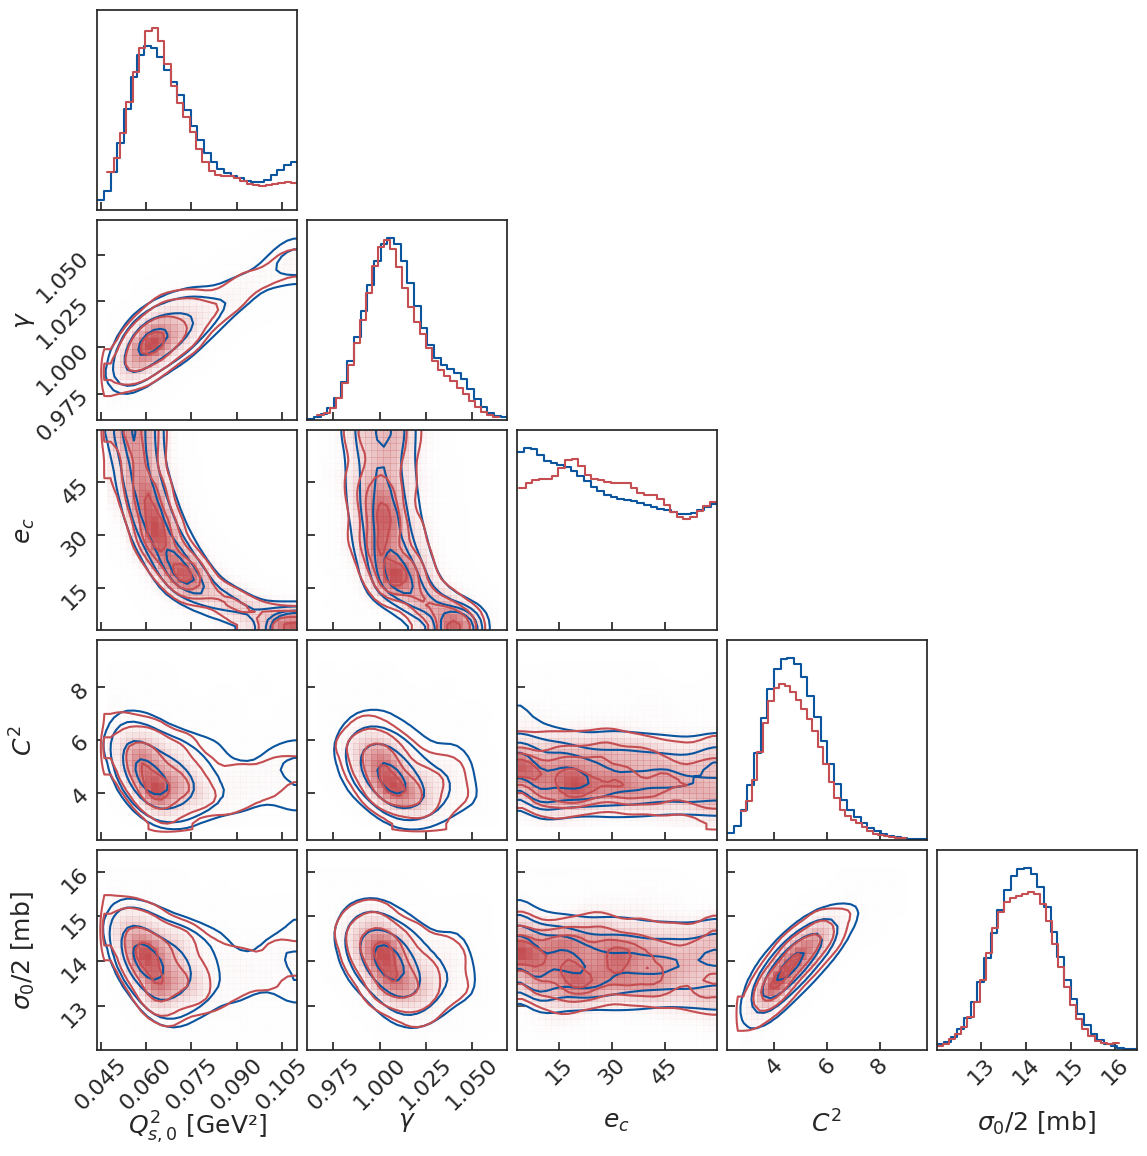

In [98]:
fig2, corner = plot_1corner(theta_post_all, param_names, color_= '#0b559f')
plot_corner_tocompare(theta_post_1000, fig2, corner, color_ = 'r')
fig2.savefig("plots/{}_{}_corner_allvs1000samples.pdf".format(model_, correlated_str), bbox_inches='tight')

In [99]:
# unravel the parameter vectors
e_cs = theta_post_1000[:, 2] if model_ == "mv5" else theta_post_1000[:, 1]
Qs02s = theta_post_1000[:, 0]
sigma02s = theta_post_1000[:, -1]
gammas = theta_post_1000[:, 1] if model_ == "mv5" else np.ones(1000)
C2 = theta_post_1000[:, 3] if model_ == "mv5" else theta_post_1000[:, 2]

Now we set up the other model as point of comparison as we calculate other observables from propagating the initial BK condition uncertainty. 

In [100]:
model_to_comp = "mv5" if model_ == "mve" else "mve"
theta_tocomp = np.vstack(np.loadtxt("data/{}/{}/theta_all.dat".format(model_to_comp, correlated_str), unpack=True)).T
theta_tocomp_1000 =  np.vstack(np.loadtxt("data/{}/{}/theta_1000.dat".format(model_to_comp, correlated_str), unpack=True)).T
e_cs_comp = theta_tocomp_1000[:, 2] if model_to_comp == "mv5" else theta_tocomp_1000[:, 1]
Qs02s_comp = theta_tocomp_1000[:, 0]
sigma02s_comp = theta_tocomp_1000[:, -1]
gammas_comp = theta_tocomp_1000[:, 1] if model_to_comp == "mv5" else np.ones(1000)
C2 = theta_post_1000[:, 3] if model_ == "mv5" else theta_post_1000[:, 2]

### Initial Dipole Amplitude Shape

In the following cells, we show the initial and evolved dipole amplitude that is constrained by the Bayesian analysis. The initial dipole amplitude is of the form:

$$ N(\mathbf{x}_{ij}, x=x_0) = 1-\exp \left[  - \frac{\left(\mathbf{x}_{ij}^2Q_{s,0}^2\right)^\gamma}{4} \right.
            \times \left. \ln \left( \frac{1}{|\mathbf{x}_{ij}| \Lambda_\text{QCD}}
             +  e_c\cdot  e   \right)   \right]. $$

We can see clearly here the model parameters that express the dipole amplitude. This is input to the BK evolution equation to evolve the dipole amplitude to higher energie and smaller $x$. The running strong coupling in the transverse plane is also input and is given by:

$$ \alpha_s(\mathbf{r}^2) = \frac{12\pi}{33-2n_f \ln\left( \frac{4C^2}{\mathbf{r}^2 \Lambda_{\mathrm{QCD}}^2} \right)}. $$

In [101]:
rs = np.logspace(-2,1,50)
iBK = get_iBK_upsd_downsd(Qs02s, gammas, e_cs, rs)
iBK_comp = get_iBK_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, rs)

# plot evolved bk now
where_bk_mve = "data/mve/corr/bks"
eBK_mve = get_eBK_upsd_downsd(where_bk_mve, rs)
where_bk_mv5 = "data/mv5/corr/bks"
eBK_mv5 = get_eBK_upsd_downsd(where_bk_mv5, rs)

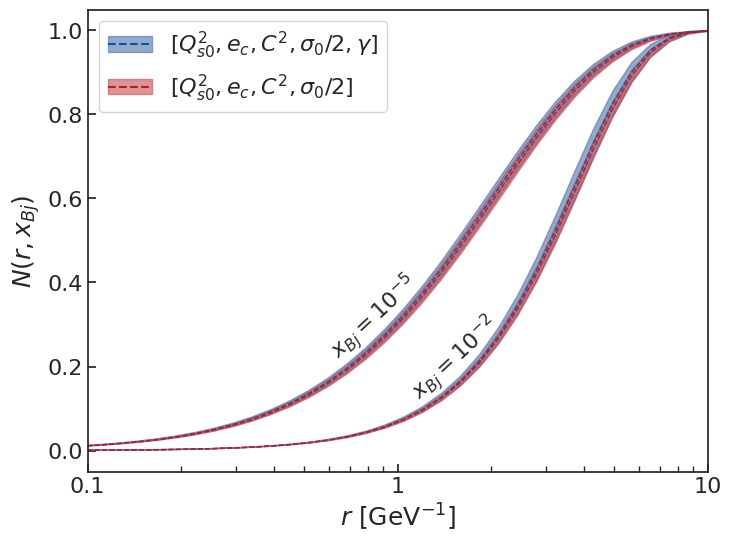

In [111]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
# plot initial and evolved bk
iBK_mve = iBK_comp if model_ == "mv5" else iBK
iBK_mv5 = iBK if model_ == "mv5" else iBK_comp

fig, ax = plt.subplots(1,1, figsize = (8,6))
plot_pred_mve_vs_mv5(fig,ax, eBK_mve, eBK_mv5, rs, linewidth_ = 1.0)
plot_pred_mve_vs_mv5(fig,ax, iBK_mve, iBK_mv5, rs, r"$N(r,x_{Bj})$", "$r$ [GeV$^{-1}$]", legend_loc = "upper left", linewidth_=1.0)

ax.set_xscale("log")
ax.set_xlim(.1, 10)
ax.text(0.38, 0.25, r'$x_{Bj} = 10^{-5}$', transform=ax.transAxes, rotation = 43, fontsize = 16)
ax.text(0.51, 0.16, r'$x_{Bj} = 10^{-2}$', transform=ax.transAxes, rotation = 43, fontsize = 16)
ax.margins(x = 0.0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
fig.savefig("plots/{}_iebk_alt.pdf".format(correlated_str), bbox_inches='tight')

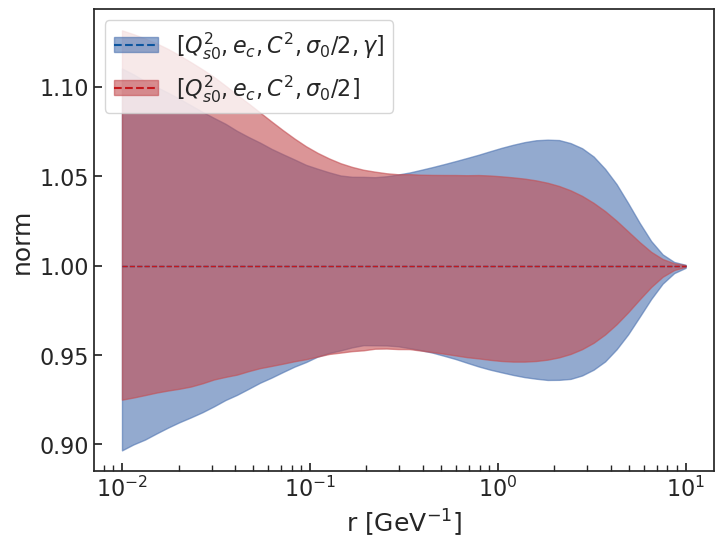

In [28]:
# normalize to 1
iBK_norm = iBK/iBK[0]
iBK_comp_norm = iBK_comp/iBK_comp[0]

#evolved bk normalize to 1
eBK_mve_norm = eBK_mve/eBK_mve[0]
eBK_mv5_norm = eBK_mv5/eBK_mv5[0]

# plot
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, iBK_comp_norm, iBK_norm, rs, 'norm', "r [GeV$^{-1}$]", legend_loc = "upper left", linewidth_=1.0)
ax.set_xscale("log")

### 2DFT Dipole Amplitude

Given the optimal parameter vector distribution, we can optimize the initial condition for the BK equation where the agreement with HERA is max. Using these "initial conditions", we can provide CGC LO prediction for observables describing pp and pA collisions at the LHC (and in the future, EIC) like particle production. One example is the 2D fourier transform of the dipole proton amplitude which can be directly calculated from the initial condition $N(r)$:


$$ \tilde{S}(k_{T}) = \int d²r e^{ik \cdot r} [1 - N(r)] = 2 \pi \int dr r J_0(k*r) (1 - N(r))$$

In [29]:
k = np.logspace(-1,1,50)
sp = get_2DFT_upsd_downsd(Qs02s, gammas, e_cs, k)
sp_comp = get_2DFT_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, k)

In [30]:
# what is the uncertainty and mean at a given k?
k_ex = [2.0]
sp_ex = get_2DFT_upsd_downsd(Qs02s_comp, gammas_comp, e_cs_comp, k_ex)
print(sp_ex[0], sp_ex[1], sp_ex[2])
print('ratio between mean and upper band:', (sp_ex[0] + 2 * sp_ex[1])/sp_ex[0])
print('ratio between mean and lower band',  (sp_ex[0] - 2 * sp_ex[2])/sp_ex[0])

[0.0001] [9.8697e-05] [2.1556e-05]
ratio between mean and upper band: [2.4844]
ratio between mean and lower band [0.6758]


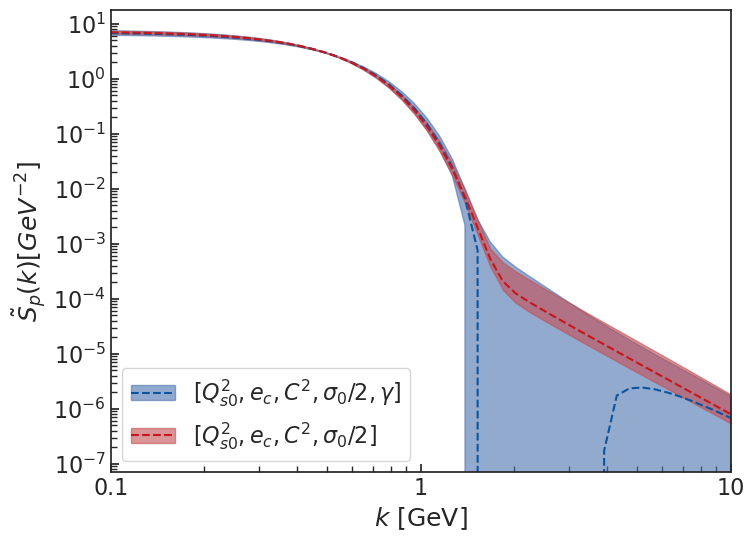

In [38]:
sp_mve = sp_comp if model_ == "mv5" else sp
sp_mv5 = sp if model_ == "mv5" else sp_comp
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, sp_mve, sp_mv5, k, r'$\tilde{S}_{p}(k) [GeV^{-2}]$', "$k$ [GeV]", legend_loc = "lower left", xlogscale= True, ylogscale = True, linewidth_=1.5)
ax.set_xlim(.1, 10)
#ax.margins(x = 0.0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
fig.savefig("plots/{}_sp.pdf".format(correlated_str), bbox_inches='tight')

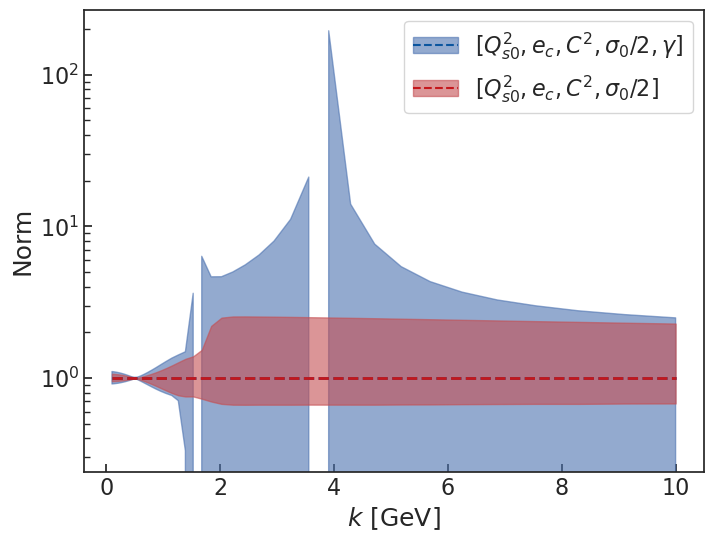

In [39]:
sp_norm = sp/sp[0]
sp_comp_norm = sp_comp/sp_comp[0]
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, sp_comp_norm, sp_norm, k, 'Norm', "$k$ [GeV]", legend_loc = "upper right", ylogscale = True)

#### RpA, nuclear modification ratio

Note: In this calculation, we do not have a routine to calculate the nuclear modification ratio, $R_{pA}$ locally, but rather have a separate script that calculates $R_{pA}$ for a given set of parameters. We instead import the datafiles from calculations we already did. 

In [40]:
where_rpa_q2_mv5 = "../BayesianBK/rpa_mv5/q2dep/"
where_rpa_q2_mve = "../BayesianBK/rpa_mve/q2dep/"
rpa_q2_mv5 = get_rpa_upsd_downsd(where_rpa_q2_mv5)
rpa_q2_mve = get_rpa_upsd_downsd(where_rpa_q2_mve)
Q2_range = np.geomspace(1, 100, 50)
x = 0.001

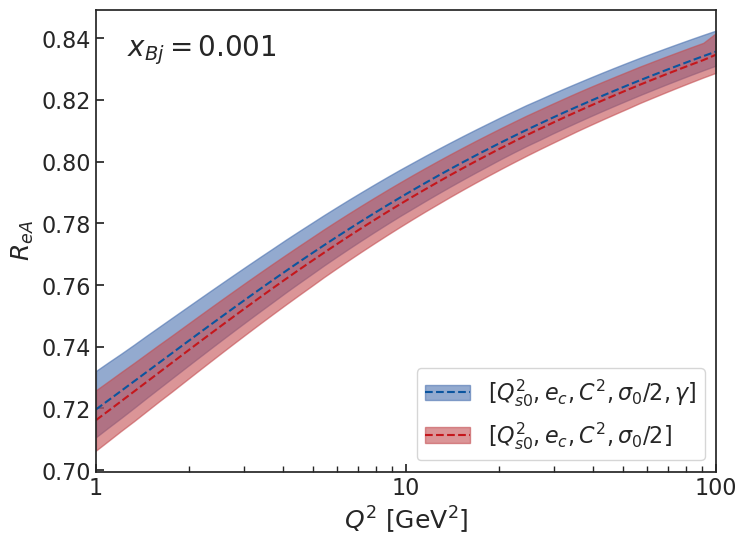

In [41]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, rpa_q2_mve, rpa_q2_mv5, Q2_range, r'$R_{eA}$', r'$Q^2$ [GeV$^2$]', legend_loc = "lower right", xlogscale= True, linewidth_= 1.5)
ax.text(0.05, 0.95, r'$x_{Bj} = $'+'{}'.format(x), transform=plt.gca().transAxes, fontsize=20, verticalalignment='top')
ax.set_xlim(1, 100)
#ax.set_axes_margin(0.0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
fig.savefig("plots/{}_rpa_q2dep.pdf".format(correlated_str), bbox_inches='tight')
fig.savefig("plots/{}_rpa_q2dep.png".format(correlated_str), bbox_inches='tight')

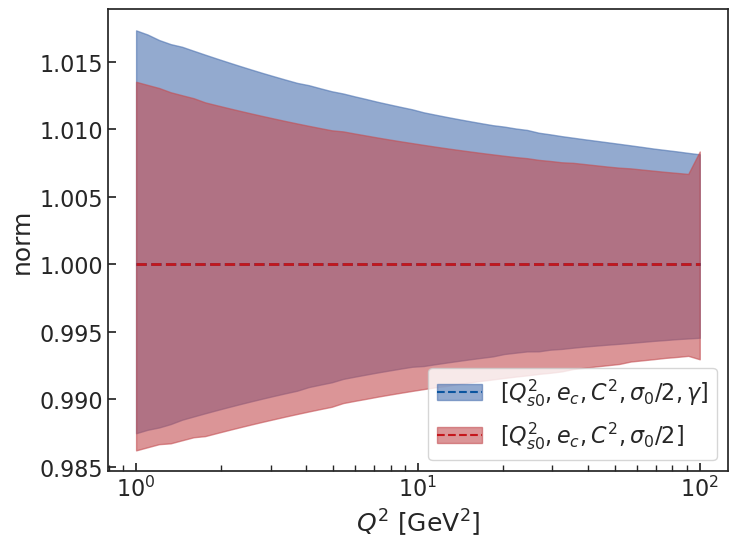

In [42]:
# normalize to 1
rpa_q2_mv5_norm = rpa_q2_mv5/rpa_q2_mv5[0]
rpa_q2_mve_norm = rpa_q2_mve/rpa_q2_mve[0]
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, rpa_q2_mve_norm, rpa_q2_mv5_norm, Q2_range, 'norm', r'$Q^2$ [GeV$^2$]', legend_loc = "lower right", xlogscale= True)

In [45]:
Q2 = 10.0
x_range = np.logspace(-5, -2, 50)
where_rpa_x_mv5 = "../BayesianBK/rpa_mv5/xdep/"
where_rpa_x_mve = "../BayesianBK/rpa_mve/xdep/"
rpa_x_mv5 = get_rpa_upsd_downsd(where_rpa_x_mv5)
rpa_x_mve = get_rpa_upsd_downsd(where_rpa_x_mve)

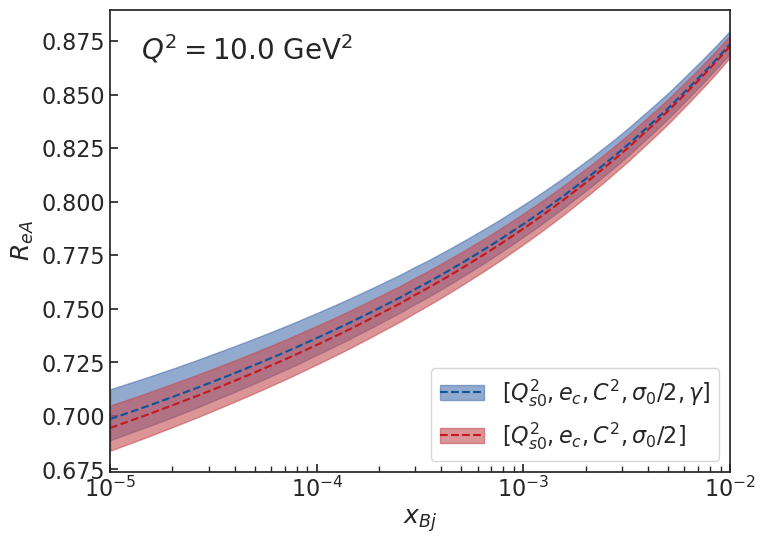

In [46]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, rpa_x_mve, rpa_x_mv5, x_range, r'$R_{eA}$', r'$x_{Bj}$', legend_loc = "lower right", xlogscale= True, linewidth_= 1.5)
ax.text(0.05, 0.95, r'$Q^2 =${} GeV$^2$'.format(Q2), transform=plt.gca().transAxes, fontsize=20, verticalalignment='top')
ax.set_xlim(1e-5, 1e-2)
#ax.set_axes_margin(0.0)
fig.savefig("plots/{}_rpa_xdep.pdf".format(correlated_str), bbox_inches='tight')
fig.savefig("plots/{}_rpa_xdep.png".format(correlated_str), bbox_inches='tight')

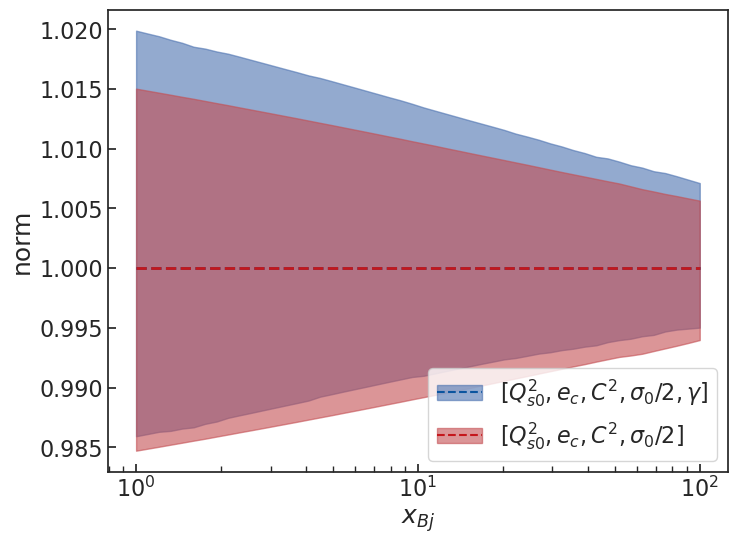

In [47]:
# typical uncertainty level
rpa_x_mv5_norm = rpa_x_mv5/rpa_x_mv5[0]
rpa_x_mve_norm = rpa_x_mve/rpa_x_mve[0]
fig, ax = plt.subplots(1,1, figsize = (8,6))
fig, ax = plot_pred_mve_vs_mv5(fig, ax, rpa_x_mve_norm, rpa_x_mv5_norm, Q2_range, 'norm', r'$x_{Bj}$', legend_loc = "lower right", xlogscale= True)